In [1]:
from copy import deepcopy

import gym
import accelerator_environments
import joss
import matplotlib.pyplot as plt
import numpy as np
import ocelot as oc
import ocelot.gui as ocg

initializing ocelot...


In [2]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
joss_env = gym.make("ARESEA-JOSS-v0")

In [3]:
print(f"Ocelot: {oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).rparticles.shape}")
print(f"JOSS: {joss.random_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).shape}")

Ocelot: (6, 100000)
JOSS: (100000, 7)


In [4]:
actuator_values = np.array([4.14, -6.94, 2.99, 0, 0])

z = 6.654039999999998 / 6.654039999999998 : applied: Ocelot: 0.00013178003874287953 / 0.00010811952600179038
JOSS: 0.00013178003874287947 / 0.00010811952600179041


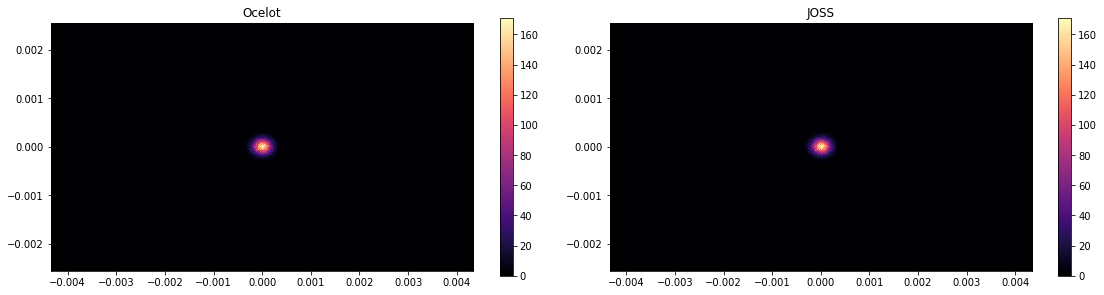

In [5]:
plt.figure(figsize=(16,4))
binning = 4
screen_resolution = (int(2448 / binning), int(2040 / binning))
meter_per_pixel = (3.5488e-6 * binning, 2.5003e-6 * binning)
screen_bin_edges = (np.linspace(-screen_resolution[0]*meter_per_pixel[0]/2,
                                screen_resolution[0]*meter_per_pixel[0]/2,
                                screen_resolution[0]+1),
                    np.linspace(-screen_resolution[1]*meter_per_pixel[1]/2,
                                screen_resolution[1]*meter_per_pixel[1]/2,
                                screen_resolution[1]+1))
screen_range = [(-screen_resolution[0] * meter_per_pixel[0] / 2,
                 screen_resolution[0] * meter_per_pixel[0] / 2),
                (-screen_resolution[1] * meter_per_pixel[1] / 2,
                 screen_resolution[1] * meter_per_pixel[1] / 2)]

import accelerator_environments.envs.ares.ARESlatticeStage3v1_9 as aresstuff
from accelerator_environments import utils
cell = utils.subcell_of(aresstuff.cell, "AREASOLA1", "Drift_ARMRBSCR1")
aresstuff.areamqzm1.k1 = actuator_values[0]
aresstuff.areamqzm2.k1 = actuator_values[1]
aresstuff.areamqzm3.k1 = actuator_values[2]
aresstuff.areamcvm1.angle = actuator_values[3]
aresstuff.areamchm1.angle = actuator_values[4]
# cell = [oc.Drift(l=3.0), oc.Quadrupole(l=1, k1=0), oc.Drift(l=0), oc.Drift(l=3)]
# cell = [oc.Drift(l=3.0)]

lattice = oc.MagneticLattice(cell)
navigator = oc.Navigator(lattice)
# particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6, sigma_p=0., chirp=0., energy=0.1, sigma_tau=0.0)
particle_array = deepcopy(particles.rparticles)
_, particles = oc.track(lattice, particles, navigator)
image, _, _ = np.histogram2d(particles.x(), particles.y(),
                             bins=(screen_resolution[0],screen_resolution[1]),
                             range=screen_range)
image = np.flipud(image.T)
print(f"Ocelot: {particles.x().std()} / {particles.y().std()}")

screen_extent = (-screen_resolution[0] * meter_per_pixel[0] / 2, screen_resolution[0] * meter_per_pixel[0] / 2,
                 -screen_resolution[1] * meter_per_pixel[1] / 2, screen_resolution[1] * meter_per_pixel[1] / 2)

plt.subplot(121)
plt.title("Ocelot")
plt.imshow(image, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()

# particles_joss = joss.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles_joss = np.ones((particle_array.shape[1], 7))
particles_joss[:,:6] = particle_array.transpose()
segment = joss.Segment(cell)
particles_joss = segment(particles_joss)
image, _, _ = np.histogram2d(particles_joss[:,0], particles_joss[:,2],
                             bins=screen_bin_edges)
image = np.flipud(image.T)
print(f"JOSS: {particles_joss[:,0].std()} / {particles_joss[:,2].std()}")

plt.subplot(122)
plt.title("JOSS")
plt.imshow(image, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()

plt.tight_layout()
plt.show()

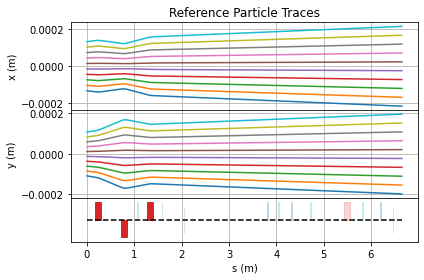

In [11]:
segment.plot_overview(particles_joss)

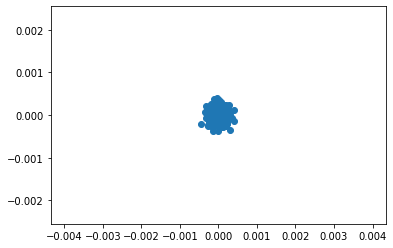

In [6]:
plt.scatter(particles_joss[:1000,0], particles_joss[:1000,2])
plt.xlim(-screen_resolution[0] * meter_per_pixel[0] / 2, screen_resolution[0] * meter_per_pixel[0] / 2)
plt.ylim(-screen_resolution[1] * meter_per_pixel[1] / 2, screen_resolution[1] * meter_per_pixel[1] / 2)
plt.show()

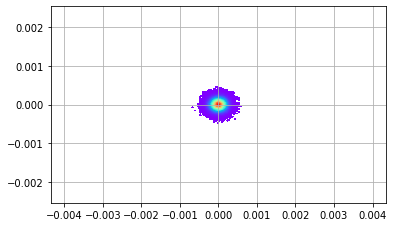

In [7]:
ocg.show_density(particles.x(), particles.y(), limits=[(-screen_resolution[0] * meter_per_pixel[0] / 2,
                                                        screen_resolution[0] * meter_per_pixel[0] / 2),
                                                       (-screen_resolution[1] * meter_per_pixel[1] / 2,
                                                       screen_resolution[1] * meter_per_pixel[1] / 2)])
plt.gca().set_aspect("equal")
plt.show()

In [8]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
ocelot_env.reset()
ocelot_screen_data = ocelot_env.read_screen()

joss_env = gym.make("ARESEA-JOSS-v0")
joss_env.reset()
joss_screen_data = joss_env.read_screen()

print(f"JOSS environment: {joss_env.particles[:,0].std()} / {joss_env.particles[:,2].std()}")
print(f"Ocelot environment: {ocelot_env.particles.x().std()} / {ocelot_env.particles.y().std()}")

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Ocelot")
plt.imshow(ocelot_screen_data, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()
plt.subplot(122)
plt.title("JOSS")
plt.imshow(joss_screen_data, cmap="magma", interpolation="None", extent=screen_extent)
plt.colorbar()
plt.tight_layout()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
joss_env.particles.shape, ocelot_env.particles.rparticles.shape

((100000, 7), (6, 100000))